# Processamento dos dados

**Autor:** Douglas Trajano

Este notebook irá atuar no processamento dos dados para treinamento do modelo que irá predizer a variável `room_type`.

As funções que irão fazer o processamento dos dados deverá estar em um arquivo **.py** com o objetivo de facilitar o deploy do modelo em um endpoint posteriormente.

A estrutura completa do projeto pode ser vista [aqui](https://github.com/DougTrajano/ds_airbnb_rio).

## / imports

In [7]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

## / load dataset

In [8]:
df = pd.read_csv("data/listings.csv", low_memory=False)
df.head()

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,is_location_exact,property_type,room_type,accommodates,bathrooms,...,amenities_mountain_view,amenities_soaking_tub,amenities_beach_view,amenities_jetted_tub,amenities_sun_loungers,amenities_high-resolution_computer_monitor,amenities_private_pool,amenities_bidet,amenities_brick_oven,amenities_hbo_go
0,0.0,100.0,1.0,2.0,1.0,1,0,0,5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,91.0,0.0,3.0,1.0,1,1,0,2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,100.0,1.0,1.0,1.0,1,1,0,3,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,100.0,1.0,1.0,1.0,1,1,0,3,1.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,100.0,1.0,1.0,1.0,1,2,0,2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## / Divisão em X e Y, normalização dos dados

In [9]:
# Split in X and Y and apply MinMaxScaler (0, 1)
from sklearn.preprocessing import MinMaxScaler

X = df.drop(columns=["room_type"])
y = df["room_type"].values

scaler = MinMaxScaler()
X = scaler.fit_transform(X.values)

print("X shape:", X.shape)

X shape: (33715, 210)


## / Balanceamento das classes

In [10]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

class_weights = {
    0: class_weights[0],
    1: class_weights[1],
    2: class_weights[2],
    3: class_weights[3]
}

print(class_weights)

{0: 0.35197519522278364, 1: 0.964719011102209, 2: 11.788461538461538, 3: 26.673259493670887}


## / PCA

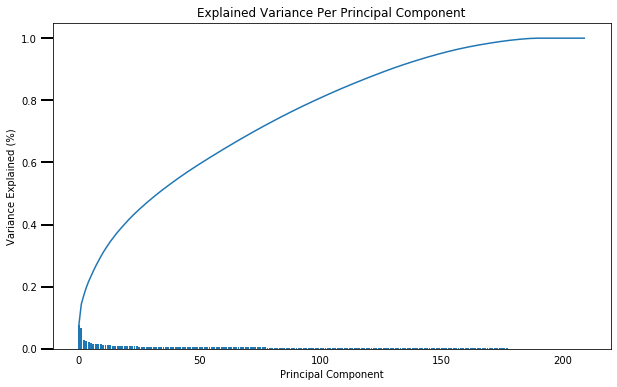

In [11]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca, X_pca = do_pca(X.shape[1], X)
X_pca = None #just cleaning memory
scree_plot(pca)

In [12]:
n_components = 100
pca, X_pca = do_pca(n_components, X)

print("Explained variance for {} components: {:.2f}%".format(n_components, sum(pca.explained_variance_ratio_)*100))

Explained variance for 100 components: 80.02%


In [13]:
print("PCA: Top 10 Explained variance", "\n")
for i in range(len(pca.explained_variance_ratio_[:10])):
    print("component {}: {:.2f}%".format(i+1, pca.explained_variance_ratio_[i]*100))

PCA: Top 10 Explained variance 

component 1: 7.76%
component 2: 6.63%
component 3: 2.77%
component 4: 2.44%
component 5: 2.05%
component 6: 1.75%
component 7: 1.69%
component 8: 1.61%
component 9: 1.48%
component 10: 1.43%


## / train test split

In [14]:
from sklearn.model_selection import train_test_split

# Split the dataset in train and test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("train size:", len(X_train))
print("test size:", len(X_test))

train size: 22589
test size: 11126


# / modeling

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=100, random_state=0, class_weight=class_weights)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9777    0.9881    0.9829      7910
           1     0.9551    0.9554    0.9553      2872
           2     0.9463    0.8017    0.8680       242
           3     1.0000    0.5294    0.6923       102

    accuracy                         0.9714     11126
   macro avg     0.9698    0.8187    0.8746     11126
weighted avg     0.9714    0.9714    0.9706     11126

